# MILESTONE 2

## **I. INTRODUCTION**

Name: Nurrahmawati

Batch: FTDS-002

### 1.1 ABOUT THE DATA

In this project, the dataset named Waste classification from Kaggle in link https://www.kaggle.com/datasets/techsash/waste-classification-data.

Waste is a problem faced by almost all countries in the world. On average every day, big cities in Indonesia produce tens of tons of trash. The waste is transported by special trucks and disposed of or just piled up in the space provided without to do
recycling. From day to day the garbage continues to pile up and
there is a garbage hill as we often see. That trash
pile it up, of course it will disturb the residents in the vicinity.
In addition to the unpleasant smell, flies often infest garbage.
And also can bring disease outbreaks.

Waste actually only consists of two types, namely organic waste and recycled waste. What is organic waste and what is waste recycleable?

Organic waste is waste that comes from nature such as waste food or leaves that can decompose easily.
While recycle waste is waste that is difficult to decompose such as waste made of plastic, rubber, glass, iron and cans.

Some of the waste will be destroyed and some are not easily destroyed. A family that puts plastic waste into it pollute the land. Waste can bring a very bad impact on public health if cann't be overcome. If the waste is disposed of haphazardly or stacked without good management, it will cause various kinds of health problems that occur in the environment. Some of us don't even realize that each every day there is accumulation of waste, both organic and organic waste
recycled waste. It should be noted that there are many causes caused by humans in disposing of waste indiscriminately.

There are still many of us who do not pay attention to disposing of trash in its place. They just realized the importance of throwing away waste in a disciplined manner, when a lot of environmental damage begins
caused by accumulated waste.

### 1.2 OBJECTIVE

To minimize the impact of waste, waste must be disposed of placed according to the type of waste to make it easier for officers to manage the waste as described above. So that the objective of this project is to make it easier for officers to distinguish between organic and recyclable waste. This project uses a deep learning model to predict the label.

## **II. IMPORT LIBRARIES**

In [28]:
# common dataframe
import pandas as pd
import numpy as np
import pathlib
from pathlib import Path
import os
import random
import cv2
import glob

# Visualization
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns

# remove all warnings, more robust
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# analyzing tools
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
from keras import layers
from keras.datasets import mnist
from keras import backend as K
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, BatchNormalization
from keras.utils.vis_utils import plot_model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import Sequential
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam, RMSprop

In [5]:
np.random.seed(1)
tf.random.set_seed(1)

## **III. DATA LOADING**

In [6]:
!mkdir -p ~/.kaggle #bikin folder di kaggle root
!cp kaggle.json ~/.kaggle # copy paster kaggle.json ke folder kaggle 

!mkdir ./kaggle #bikin folder kaggle di lokasi sama (bukan di root)
!mv ./kaggle.json ./kaggle #move atau pindahi file kaggle.json ke folder kaggle

mkdir: cannot create directory ‘./kaggle’: File exists


In [7]:
!chmod 600 ~/.kaggle/kaggle.json #perizinan akses, hanya pemilik file yang memiliki akses baca dan tulis ke file
!ls ~/.kaggle #cek list data yang ada di folder kaggle

kaggle.json


In [8]:
!kaggle datasets download -d techsash/waste-classification-data

 97% 414M/427M [00:03<00:00, 170MB/s]
100% 427M/427M [00:03<00:00, 121MB/s]


In [9]:
# !unzip -q /content/waste-classification-data.zip -d dataset
!unzip -q /content/waste-classification-data.zip -d dataset

First, we need to define the data directory for this project.

In [10]:
main_path= '/content/dataset/dataset/DATASET'

In [11]:
# Specify the root paths
train_path = os.path.join(main_path, 'TRAIN')
test_path = os.path.join(main_path, 'TEST')

### 3.1 FINDING TOTAL CLASSES

After the data has been loaded into the notebook, the next step is to check how many images we have. In the cell below, we are counting the total images in train and test directory.

In [ ]:
# Get the Class Names
class_names = sorted(os.listdir(train_path))
n_classes = len(class_names)

# Show
print(f"Number of Classes : {n_classes}\nClass Names : {class_names}")

Number of Classes : 2
Class Names : ['O', 'R']


There are 2 classes of images in the dataset. There are 'O' and 'R', which 'O' is defined as organic waste and 'R' is defined as recycle waste

In [ ]:
# checking ammount of samples of each labels in data train
print('image set: \n' + '='*50)
num_organic= len(os.listdir(os.path.join(train_path, 'O')))
num_recycle= len(os.listdir(os.path.join(train_path, 'R')))

print(f'organic ammount= {num_organic}')
print(f'recycle ammount= {num_recycle}')

image set: 
organic ammount= 12565
recycle ammount= 9999


As it can be seen from above there are about 12565 images for organic classes and 9999 images for recycle classes.

### 3.2 CREATING DATAFRAME

In [12]:
# fetching image data directory
train_organic = glob.glob(train_path+"/O/*.jpg")
train_recycle = glob.glob(train_path+"/R/*.jpg")

test_organic = glob.glob(test_path+"/O/*.jpg")
test_recycle = glob.glob(test_path+"/R/*.jpg")

In [13]:
# Defining dataframe function
def create_dataframe(list_of_images):
    data = []
    for image in list_of_images:
        data.append((image, image.split('\\')[0].split('/')[-2]))
    return pd.DataFrame(data, columns=['images', 'label'])

In [14]:
# creating dataframe for data train
train_df= create_dataframe(train_organic + train_recycle)
train_df= train_df.sample(frac=1, random_state=1).reset_index(drop=True)

# creating dataframe for data test
test_df= create_dataframe(test_organic + test_recycle)
test_df= test_df.sample(frac=1, random_state=1).reset_index(drop=True)

In [ ]:
tr = train_df.shape
te = test_df.shape

print(f'shape of data train: {tr}')
print(f'shape of data test: {te}')

shape of data train: (22564, 2)
shape of data test: (2513, 2)


After we create a dataframe we can see that there are around 22500 images for training and 2500 images for testing. As we already know that the sample image in this data is quite large which will probably hinder to our work in modeling later, because of the limitations of the device used. So we will use 5000 images for training and 800 images for testing.

In [21]:
dataset_final = train_df.sample(5000, random_state=10)

### 3.3 RENAMING CLASSES NAMES

I have checked those 2 classes by directly accessing the images and from those images. Here are the classes based on each image's classes.

In [22]:
dataset_final.label.replace({'O': 'Organic', 'R': 'Recycle'}, inplace=True)

In [23]:
dataset_final.head()

,images,label
500,/content/dataset/dataset/DATASET/TRAIN/R/R_454...,Recycle
21504,/content/dataset/dataset/DATASET/TRAIN/R/R_155...,Recycle
1986,/content/dataset/dataset/DATASET/TRAIN/O/O_121...,Organic
22301,/content/dataset/dataset/DATASET/TRAIN/O/O_105...,Organic
20786,/content/dataset/dataset/DATASET/TRAIN/R/R_363...,Recycle


## **IV. EXPLORATORY DATA ANALYSIS**

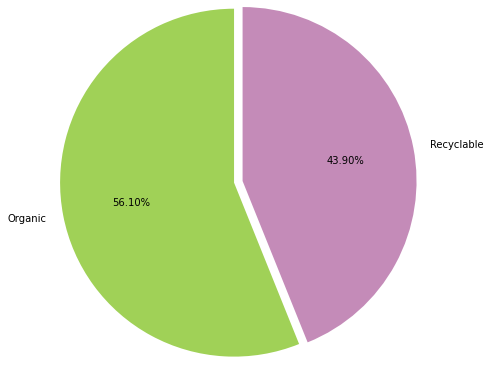

In [24]:
colors = ['#a0d157','#c48bb8']
plt.pie(dataset_final.label.value_counts(),startangle=90,explode=[0.05,0.05],autopct='%0.2f%%',
        labels=['Organic', 'Recyclable'], colors= colors,radius=2)
plt.show()

We can see in the pie chart above, there is 56.1% for organic waste and 43.9% for recycle waste in the data train, even though the proportions between the two labels are not the same, but we can say that this data includes a balance so we don't need to do balancing on data.

In [25]:
# Get few samples for both the classes
Organic_samples = (dataset_final[dataset_final['label']=="Organic"]['images'].iloc[:5]).tolist()
Recycle_samples = (dataset_final[dataset_final['label']=='Recycle']['images'].iloc[:5]).tolist()

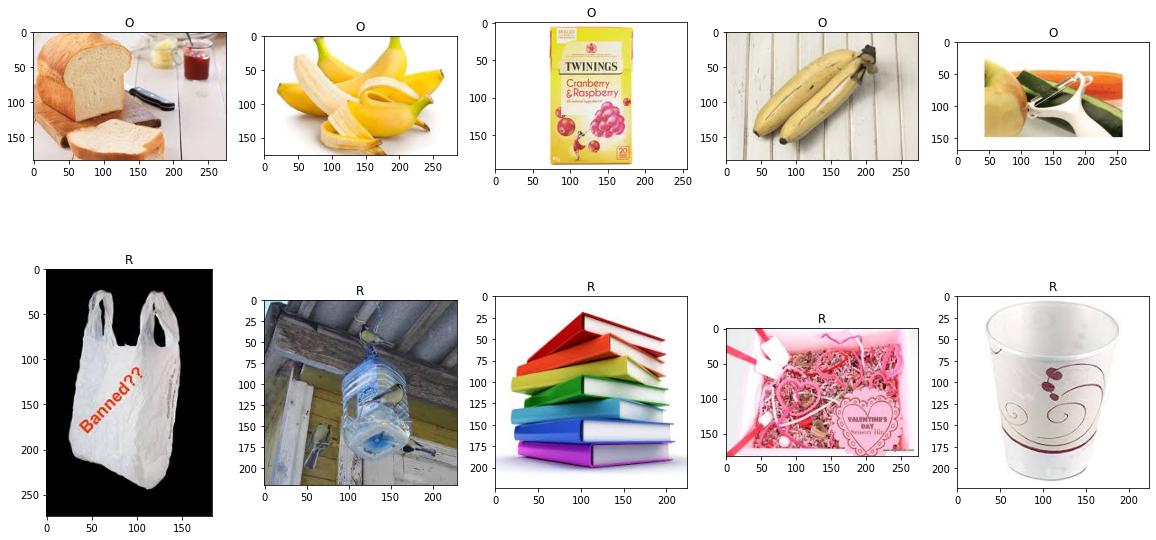

In [26]:
# visualize sample images
def visualize_samples(samples):
    fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(20,10))
    for i, sample in enumerate(samples):
        img = cv2.imread(sample)
        ax[i//5, i%5].set_title(sample.split('\\')[0].split('/')[-2])
        ax[i//5, i%5].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

visualize_samples(Organic_samples + Recycle_samples)

As can be seen from above, We have visualized several images from 2 classes randomly and in these images have different sizes.

## **V. DATA PREPROCESSING**

### 5.1 RESIZING THE IMAGES

The images that have been loaded comes in many size ranging from about 150x150 pixels to 250x250 pixels.

In the below cell, we will define the width and height of images for resizing purposes. 

In [34]:
img_height= 224
img_width= 224
seed_num = 1
batch_num =32

### 5.2 SPLITTING THE DATA

Now, the training data will be splitted into two different parts, which are train and validation with the proportion of validation data is 20% of the total training data.

In [30]:
def visualize_data(dataframe, label):
    fig, ax = plt.subplots(figsize =(8, 5))
    ax = sns.countplot(x='label', data=dataframe, palette='Set2')
    ax.set_title('Data Distribution')
    ax.set_xlabel('Label')
    ax.set_ylabel('Count')
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.2f'),
                   (p.get_x() + p.get_width() / 2,
                    p.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 5),
                   textcoords='offset points')
    
    # Setting the label for x-axis
    plt.xlabel("Label", size=14)
    # Setting the label for y-axis
    plt.ylabel("Jumlah", size=14)
    # plt title base on name of 
    plt.title(f"{label} Distribution", size=10)
    plt.show()

Train Size :  (3200, 2)


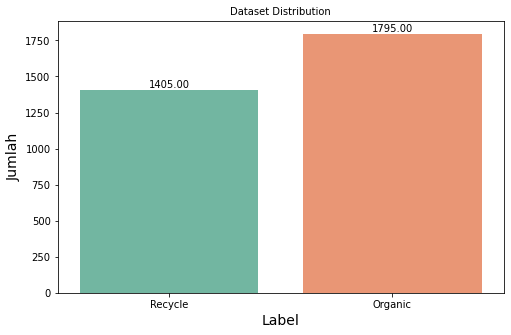

Validation Size:  (800, 2)


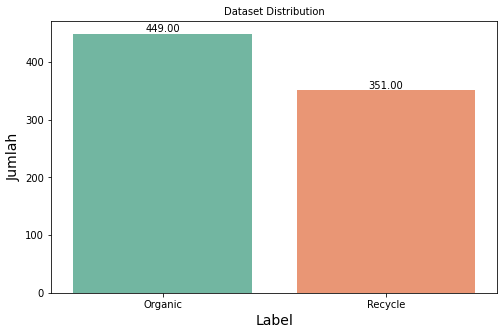

Test Size  :  (1000, 2)


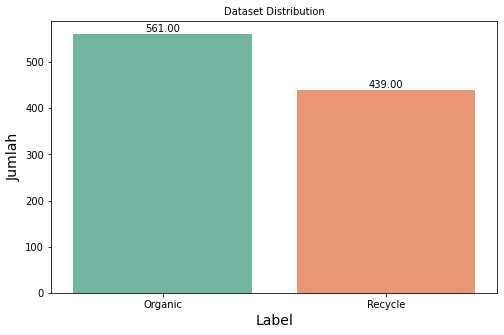

In [31]:
# defining y
y = dataset_final['label']
# Splitting training, validation and test data
df_train_full, df_test, y_train_full, y_test  = train_test_split(dataset_final,y, test_size=0.2, random_state=42,stratify=y)
df_train, df_val,y_train,y_val = train_test_split(df_train_full,y_train_full, test_size=0.2, random_state=43,stratify=y_train_full)

print('Train Size : ', df_train.shape)
visualize_data(df_train, 'Dataset')
print('Validation Size: ', df_val.shape)
visualize_data(df_val, 'Dataset')
print('Test Size  : ', df_test.shape)
visualize_data(df_test, 'Dataset')

### 5.3 AUGMENTING IMAGE DATA

Here we will augment the images by using ImageDataGenerator.

In [32]:
# augmenting image data
train_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=0,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode='nearest'
)

val_aug = ImageDataGenerator(rescale=1./255)
test_aug = ImageDataGenerator(rescale=1./255)

In [35]:
df_train_aug = train_aug.flow_from_dataframe(
    dataframe=df_train,
    x_col='images',
    y_col='label',
    target_size=(img_height, img_width),
    class_mode='categorical',
    batch_size=batch_num,
    shuffle=True,
    seed=seed_num)

df_val_aug = val_aug.flow_from_dataframe(
    dataframe=df_val,
    x_col='images',
    y_col='label',
    target_size=(img_height, img_width),
    class_mode='categorical',
    batch_size=batch_num,
    shuffle=False,
    seed=seed_num)

df_test_aug = test_aug.flow_from_dataframe(
    dataframe=df_test,
    x_col='images',
    y_col='label',
    target_size=(img_height, img_width),
    class_mode='categorical',
    batch_size=batch_num,
    shuffle=False,
    seed=seed_num)

Found 3200 validated image filenames belonging to 2 classes.
Found 800 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames belonging to 2 classes.


## **VI. DEEP LEARNING MODELING**

In this section, we will define the deep learning model by using Sequential API method.

### 6.1 BASE MODEL

#### 6.1.1 MODEL DEFINITION

In [ ]:
# Defining the layers

model = keras.models.Sequential([   
    layers.InputLayer(input_shape=(img_height,img_width,3)), 
    keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
    keras.layers.MaxPool2D(),
    
    keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
    keras.layers.MaxPool2D(),
    
    keras.layers.Flatten(),
    keras.layers.Dense(25, activation='relu'),
    keras.layers.Dense(2, activation='sigmoid')
])

In [ ]:
# Defining the parameters

lr = 0.01
epochs = 5
opt = Adam(learning_rate=lr)


#### 6.1.2 MODEL COMPILING

In [ ]:
# Compiling the Model
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
# Model Summarize
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 112, 112, 16)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 flatten_6 (Flatten)         (None, 100352)            0         
                                                                 
 dense_15 (Dense)            (None, 25)               

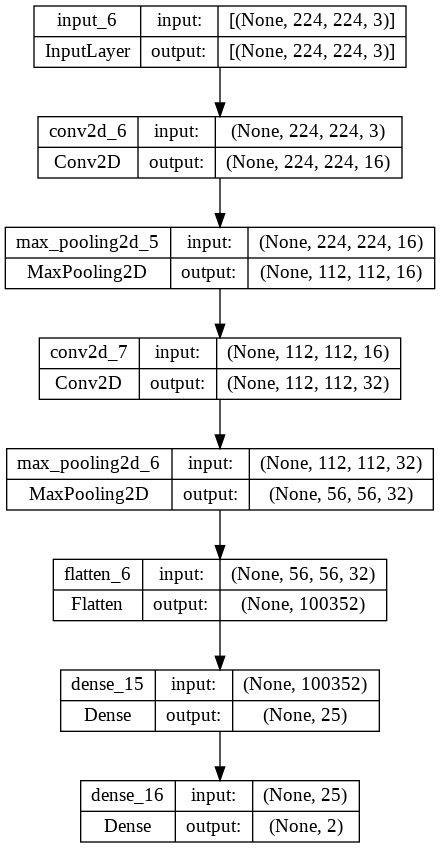

In [ ]:
# Model plotting
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

#### 6.1.3 MODEL TRAINING

In [ ]:
#  Training the model
history = model.fit(df_train_aug, epochs=epochs, validation_data=df_val_aug)

Epoch 1/5
100/100 [==============================] - 37s 367ms/step - loss: 1.1227 - accuracy: 0.5587 - val_loss: 0.6863 - val_accuracy: 0.5612
Epoch 2/5
100/100 [==============================] - 38s 380ms/step - loss: 0.6865 - accuracy: 0.5609 - val_loss: 0.6859 - val_accuracy: 0.5612
Epoch 3/5
100/100 [==============================] - 36s 364ms/step - loss: 0.6861 - accuracy: 0.5609 - val_loss: 0.6857 - val_accuracy: 0.5612
Epoch 4/5
100/100 [==============================] - 36s 363ms/step - loss: 0.6866 - accuracy: 0.5609 - val_loss: 0.6859 - val_accuracy: 0.5612
Epoch 5/5
100/100 [==============================] - 38s 377ms/step - loss: 0.6861 - accuracy: 0.5609 - val_loss: 0.6856 - val_accuracy: 0.5612


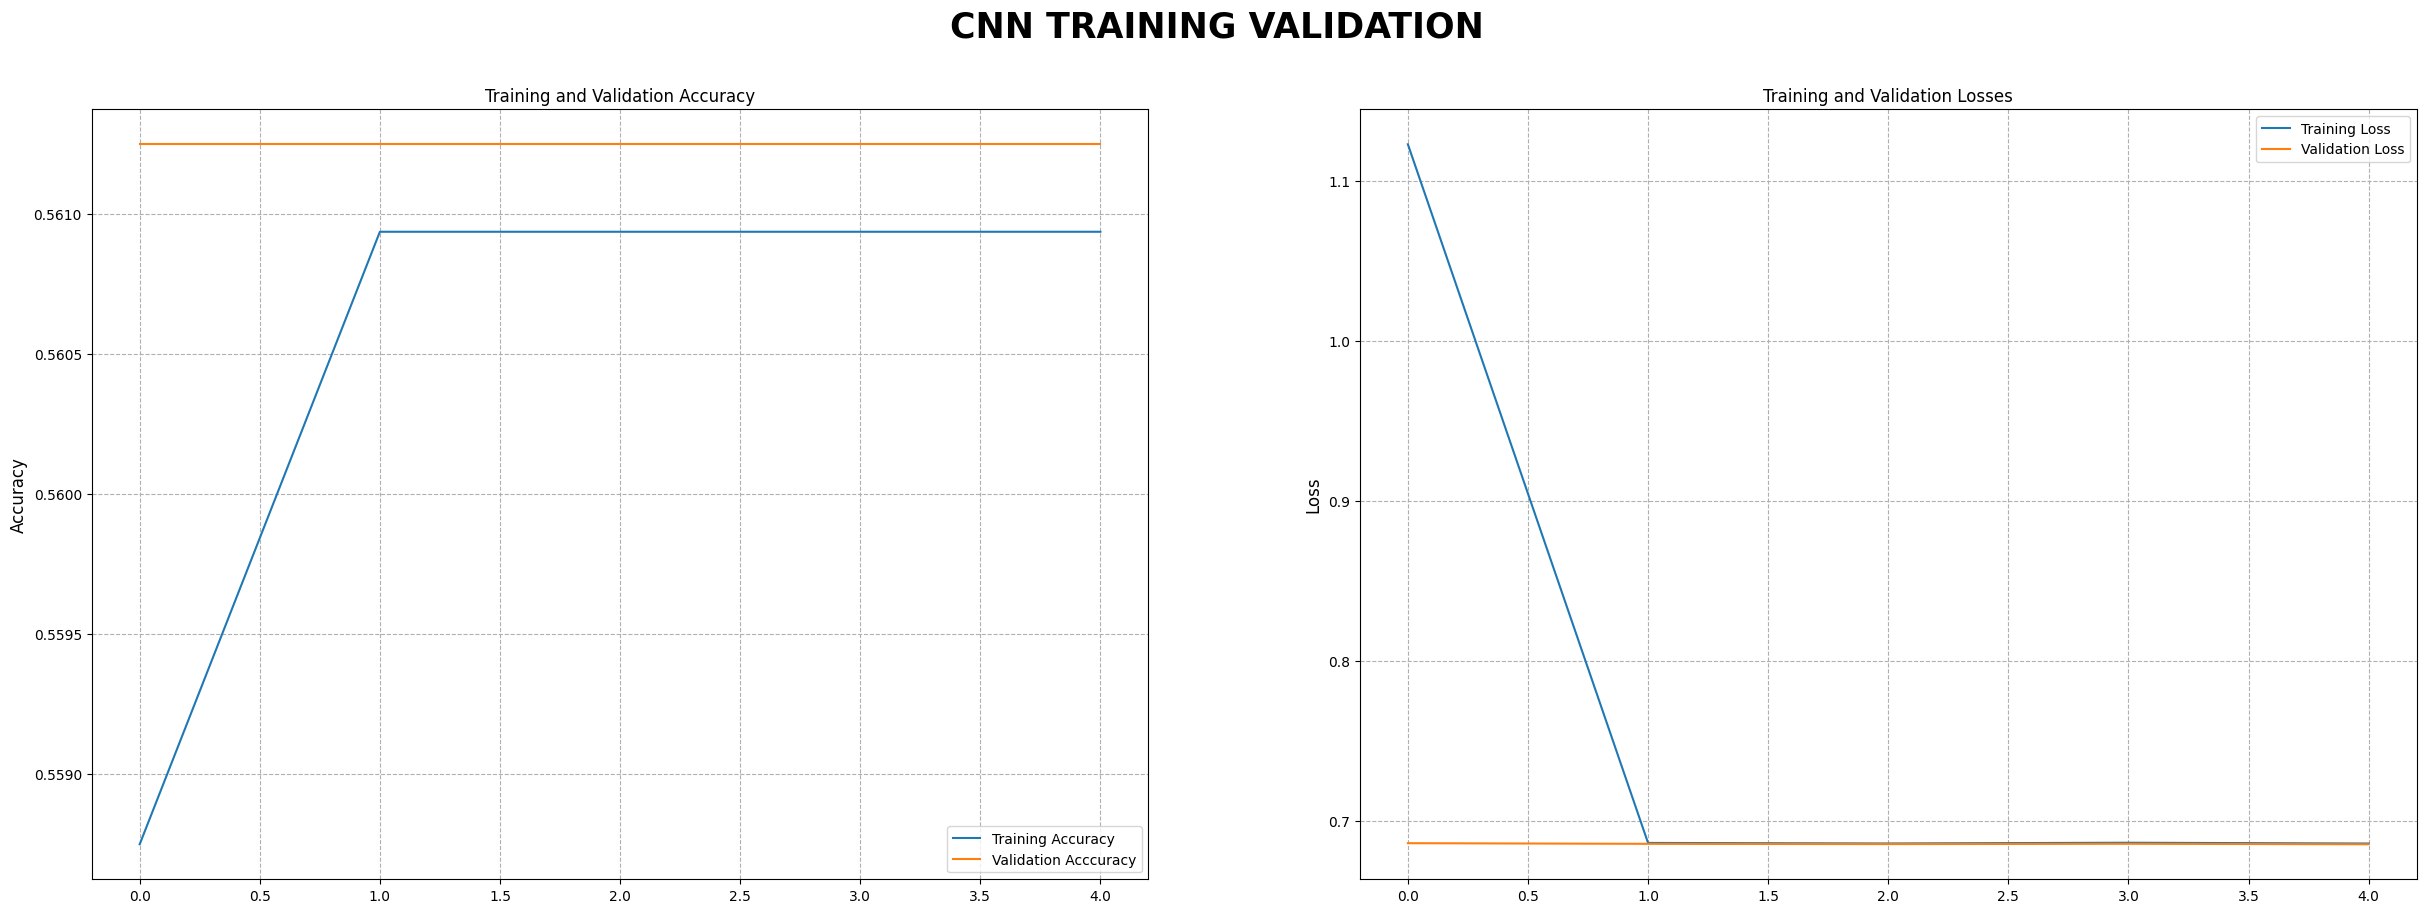

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(30,10))
fig.suptitle('CNN TRAINING VALIDATION', fontsize=25, weight='bold')

plt.subplot(1,2,1)
plt.title("Training and Validation Accuracy", fontsize=12)
plt.plot(history.history['accuracy'],label="Training Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Acccuracy")
plt.ylabel("Accuracy", fontsize=12)
plt.legend()
plt.grid(linestyle='--')

plt.subplot(1,2,2)
plt.title("Training and Validation Losses", fontsize=12)
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.ylabel("Loss", fontsize=12)
plt.legend()
plt.grid(linestyle='--')

plt.style.use('default')
plt.show()

The graphs above tells us the accuracy and the loss of the model that just have been trained. As it can be seen from the left graph, the accuracy of the model is still not performing well, the highest accuracy is 0.5609 while the validation is 0.5612. In addition to this result, there is a vanishing gradient problem. The vanishing gradient problem is caused by the derivative of the activation function used to create the neural network. The simplest solution to the problem is to replace the activation function of the network. So we will try to manually improve the model in the next section.

In [ ]:
model.trainable = False

### 6.2 IMPROVING MODEL

As we have mentioned before, we will try to improve the model in this section by tuning the layers and optimizers and we will also using callback function and reduce learning rate.

#### 6.2.1 MODEL DEFINITION

In [ ]:
# defining the improved model by adding more layers
IMP_model = keras.models.Sequential([   
    layers.InputLayer(input_shape=(img_height,img_width,3)), 
    keras.layers.Conv2D(16, 3, activation='relu'),
    keras.layers.Conv2D(32, 3, activation='relu'),
    keras.layers.MaxPool2D(),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Flatten(),
    keras.layers.Dense(25, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(2, activation='sigmoid')
])


In [ ]:
#Callback checkpoint untuk save model setiap menemukan metrik yang terbaik, disini diset validation loss
checkpoint = ModelCheckpoint('Waste_Classsification_Model.h5',
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             verbose=1)

#Callback untuk menghentikan training jika val_lossnya paling rendah dengan menunggu 3 epoch selanjutnya baru berhenti jika tidak ada improvisasi
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True
                          )

#Mengurangi nilai learning rate ketika model tidak mengalami improvisasi selama 3 epoch berturut-turut
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)

#### 6.2.2 MODEL COMPILING

In [ ]:
# compiling the improved model
IMP_model.compile(loss='binary_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

In [ ]:
# summarizing the improved model
IMP_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 222, 222, 16)      448       
                                                                 
 conv2d_9 (Conv2D)           (None, 220, 220, 32)      4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 110, 110, 32)     0         
 2D)                                                             
                                                                 
 batch_normalization_11 (Bat  (None, 110, 110, 32)     128       
 chNormalization)                                                
                                                                 
 flatten_7 (Flatten)         (None, 387200)            0         
                                                                 
 dense_17 (Dense)            (None, 25)               

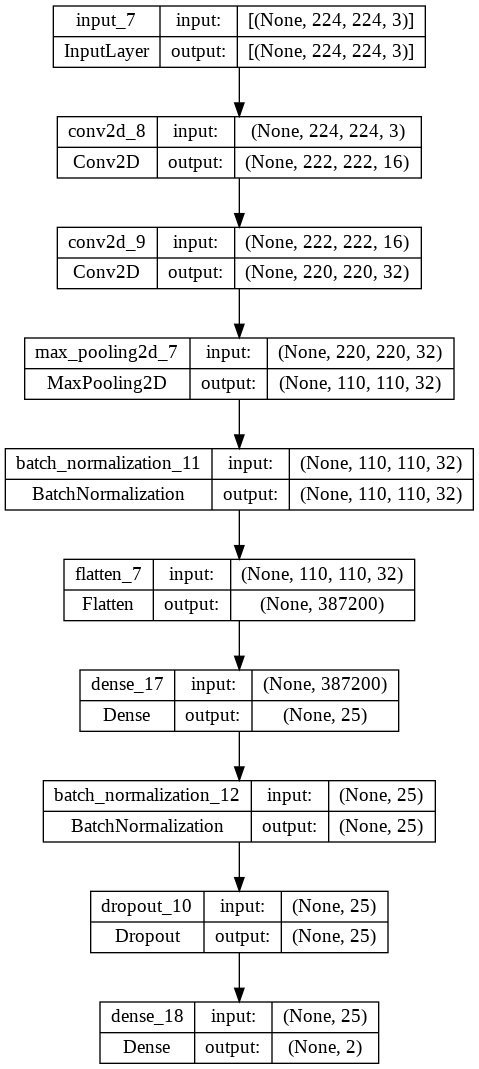

In [ ]:
# Model plotting
tf.keras.utils.plot_model(IMP_model, show_shapes=True, show_layer_names=True)

#### 6.2.3 MODEL TRAINING

In [ ]:
# Training the model
IMP_history = IMP_model.fit(df_train_aug, validation_data=df_val_aug, epochs=50, 
                            callbacks=[checkpoint, earlystop, reduce_lr], shuffle=True, batch_size=32)

Epoch 1/50
100/100 [==============================] - ETA: 0s - loss: 0.5782 - accuracy: 0.7678
Epoch 1: val_loss improved from inf to 0.54191, saving model to Waste_Classsification_Model.h5
100/100 [==============================] - 38s 381ms/step - loss: 0.5782 - accuracy: 0.7678 - val_loss: 0.5419 - val_accuracy: 0.7800 - lr: 0.0010
Epoch 2/50
100/100 [==============================] - ETA: 0s - loss: 0.5140 - accuracy: 0.7844
Epoch 2: val_loss did not improve from 0.54191
100/100 [==============================] - 39s 391ms/step - loss: 0.5140 - accuracy: 0.7844 - val_loss: 0.6400 - val_accuracy: 0.5813 - lr: 0.0010
Epoch 3/50
100/100 [==============================] - ETA: 0s - loss: 0.4906 - accuracy: 0.7987
Epoch 3: val_loss improved from 0.54191 to 0.47286, saving model to Waste_Classsification_Model.h5
100/100 [==============================] - 37s 370ms/step - loss: 0.4906 - accuracy: 0.7987 - val_loss: 0.4729 - val_accuracy: 0.8087 - lr: 0.0010
Epoch 4/50
100/100 [==========

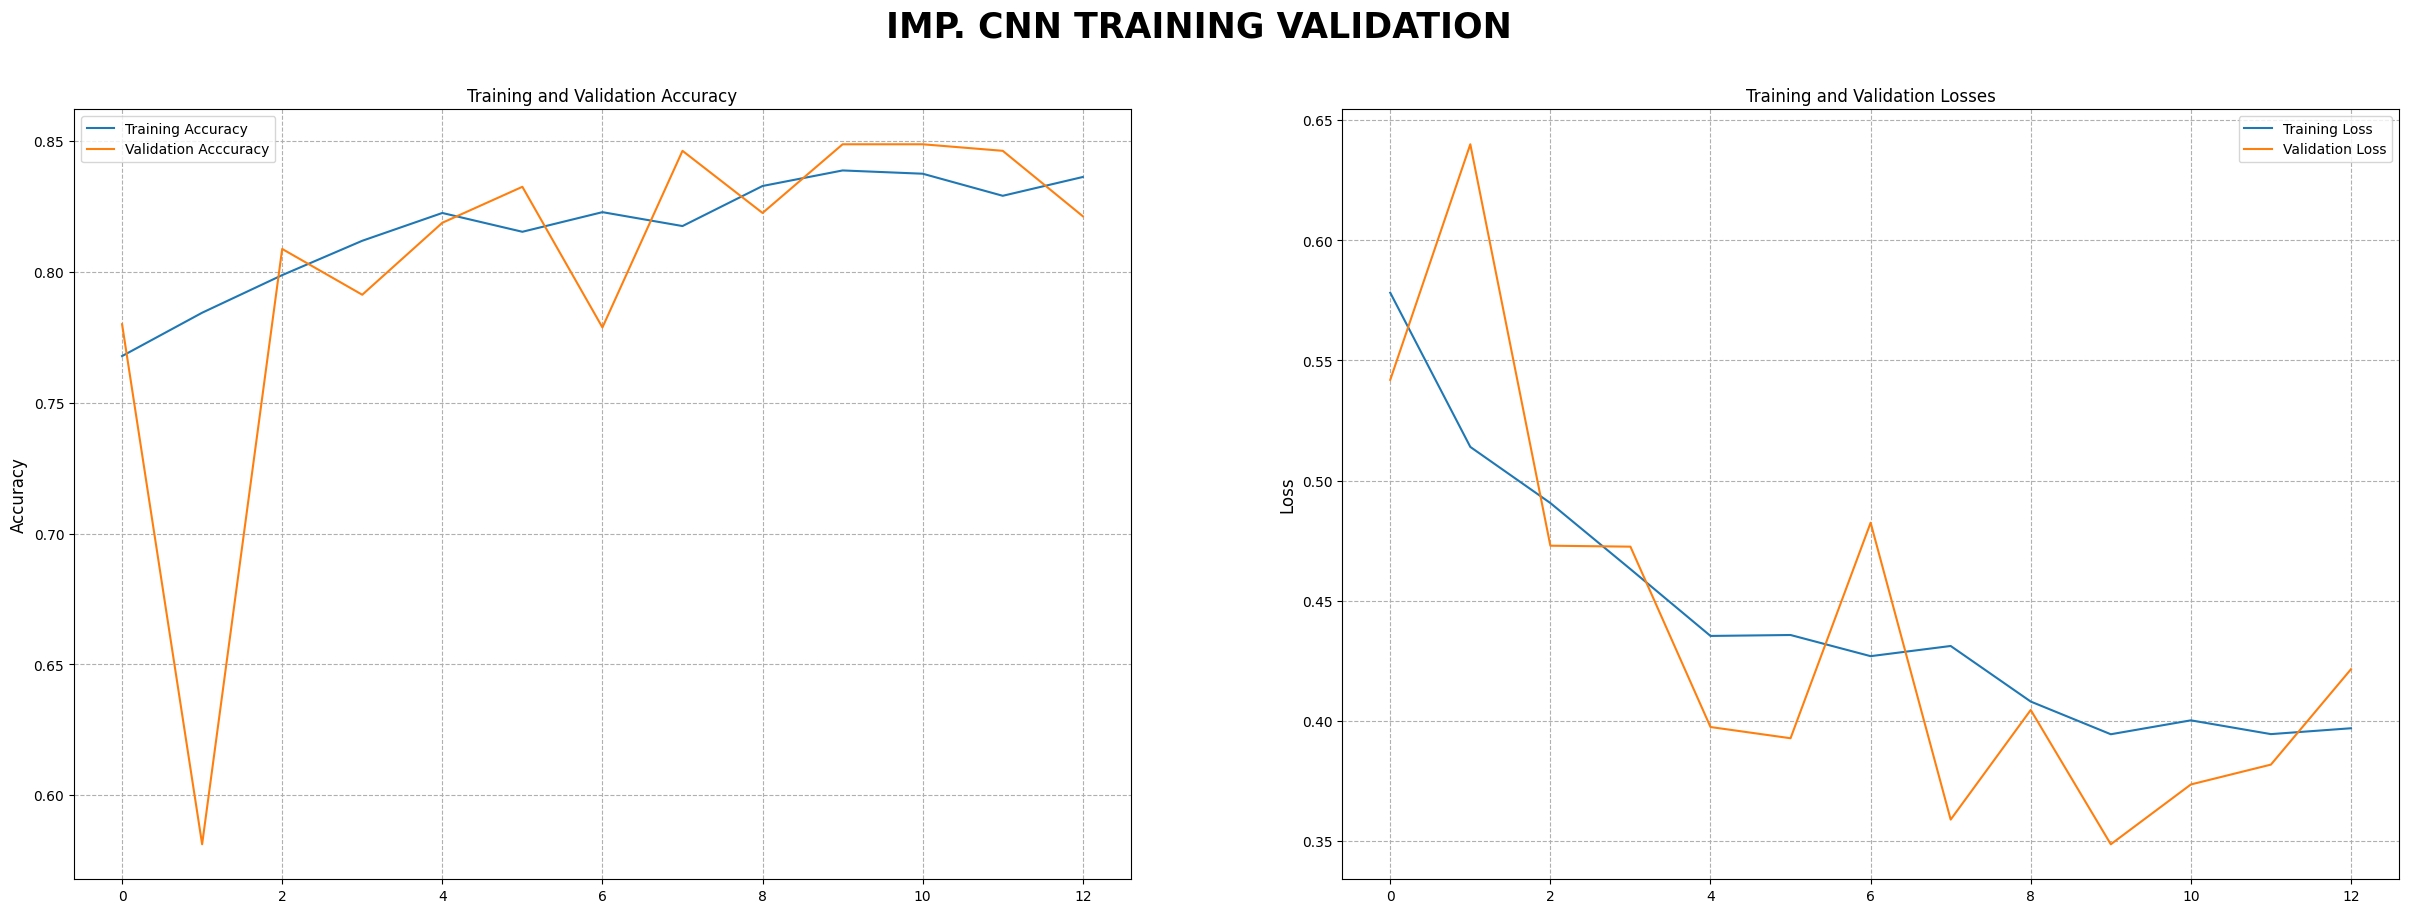

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(30,10))
fig.suptitle('IMP. CNN TRAINING VALIDATION', fontsize=25, weight='bold')

plt.subplot(1,2,1)
plt.title("Training and Validation Accuracy", fontsize=12)
plt.plot(IMP_history.history['accuracy'],label="Training Accuracy")
plt.plot(IMP_history.history['val_accuracy'], label="Validation Acccuracy")
plt.ylabel("Accuracy", fontsize=12)
plt.legend()
plt.grid(linestyle='--')

plt.subplot(1,2,2)
plt.title("Training and Validation Losses", fontsize=12)
plt.plot(IMP_history.history['loss'], label="Training Loss")
plt.plot(IMP_history.history['val_loss'], label="Validation Loss")
plt.ylabel("Loss", fontsize=12)
plt.legend()
plt.grid(linestyle='--')

plt.style.use('default')
plt.show()

It can be seen from the two graphs above, the model that has been created and improved has a significant increase in prediction results from the previous one. However, when viewed from the two graphs, we can see that the validation accuracy value had a higher value than the training accuracy value. We will try again to manually improve the model in the next section.

In [ ]:
train_results = IMP_model.evaluate(df_train_aug, verbose=0)
print(f'Train Loss     : {train_results[0]:.4f}')
print(f'Train Accuracy : {train_results[1]:.4f}')

Train Loss     : 0.3567
Train Accuracy : 0.8434


In [ ]:
IMP_model.trainable = False

### 6.3 IMPROVING MODEL WITH VGG16

As we have mentioned before, we will try to improve the model in this section by tuning the layers and we will also using callback function and reduce learning rate and then we also use VGG16 addition on improving this model

#### 6.3.1 MODEL DEFINITION

In [ ]:
# Defining VGG16
base_model = VGG16(input_shape=(224,224,3), 
                   include_top=False,
                   weights="imagenet")

In [ ]:
# Freezing Layers 
for layer in base_model.layers:
    layer.trainable=False

In [ ]:
# Summary
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# Defining Layers
model3=Sequential()
model3.add(base_model)
model3.add(Dropout(0.2))
model3.add(Flatten())
model3.add(BatchNormalization())
model3.add(Dense(32,kernel_initializer='he_uniform'))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(Dropout(0.2))
model3.add(Dense(64,kernel_initializer='he_uniform'))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(Dropout(0.2))
model3.add(Dense(2,activation='sigmoid'))

In [ ]:
# Defining Callbacks
filepath = './best_weights.h5'

earlystopping = EarlyStopping(monitor = 'val_accuracy', 
                              mode = 'max' , 
                              patience = 3,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_accuracy', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)

reduce_lrt = ReduceLROnPlateau(monitor='val_accuracy',
                              mode='max',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)

callback_list = [earlystopping, checkpoint, reduce_lrt]

#### 6.3.2 MODEL COMPILING

In [ ]:
# Model Compile 
OPT    = RMSprop()

model3.compile(loss='binary_crossentropy',
              metrics=['accuracy'],
              optimizer=OPT)

In [ ]:
# Summary
model3.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 dropout_11 (Dropout)        (None, 7, 7, 512)         0         
                                                                 
 flatten_8 (Flatten)         (None, 25088)             0         
                                                                 
 batch_normalization_13 (Bat  (None, 25088)            100352    
 chNormalization)                                                
                                                                 
 dense_19 (Dense)            (None, 32)                802848    
                                                                 
 batch_normalization_14 (Bat  (None, 32)               128       
 chNormalization)                                     

#### 6.3.3 MODEL TRAINING

In [ ]:
# Model Training
model_history=model3.fit(df_train_aug,
                        validation_data=df_val_aug,
                        epochs = 20,
                        callbacks = callback_list,
                        verbose = 1)

Epoch 1/20
100/100 [==============================] - ETA: 0s - loss: 0.4532 - accuracy: 0.8122
Epoch 1: val_accuracy improved from -inf to 0.88625, saving model to ./best_weights.h5
100/100 [==============================] - 44s 425ms/step - loss: 0.4532 - accuracy: 0.8122 - val_loss: 0.2982 - val_accuracy: 0.8863 - lr: 0.0010
Epoch 2/20
100/100 [==============================] - ETA: 0s - loss: 0.3505 - accuracy: 0.8694
Epoch 2: val_accuracy improved from 0.88625 to 0.89000, saving model to ./best_weights.h5
100/100 [==============================] - 45s 448ms/step - loss: 0.3505 - accuracy: 0.8694 - val_loss: 0.2669 - val_accuracy: 0.8900 - lr: 0.0010
Epoch 3/20
100/100 [==============================] - ETA: 0s - loss: 0.3113 - accuracy: 0.8850
Epoch 3: val_accuracy improved from 0.89000 to 0.90750, saving model to ./best_weights.h5
100/100 [==============================] - 44s 440ms/step - loss: 0.3113 - accuracy: 0.8850 - val_loss: 0.2513 - val_accuracy: 0.9075 - lr: 0.0010
Epoc

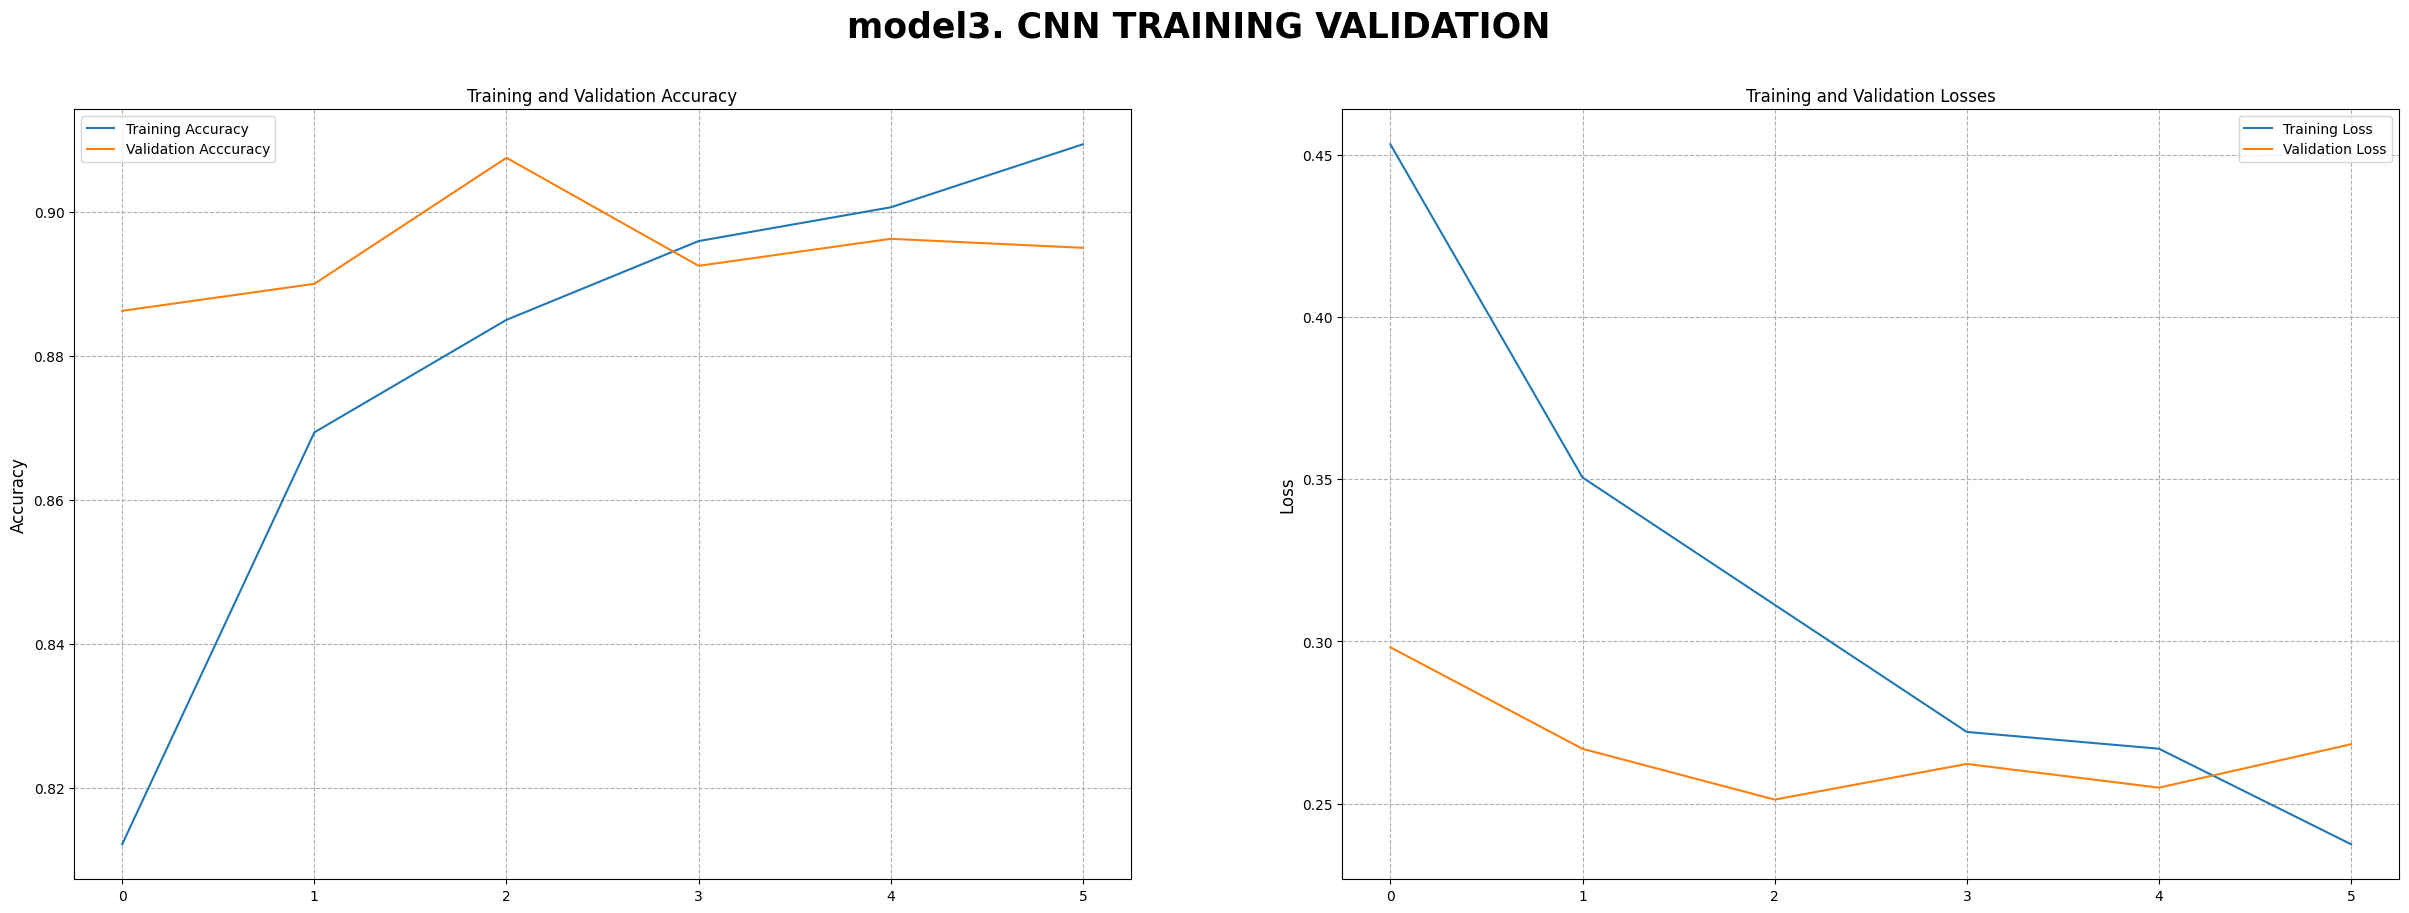

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(30,10))
fig.suptitle('model3. CNN TRAINING VALIDATION', fontsize=25, weight='bold')

plt.subplot(1,2,1)
plt.title("Training and Validation Accuracy", fontsize=12)
plt.plot(model_history.history['accuracy'],label="Training Accuracy")
plt.plot(model_history.history['val_accuracy'], label="Validation Acccuracy")
plt.ylabel("Accuracy", fontsize=12)
plt.legend()
plt.grid(linestyle='--')

plt.subplot(1,2,2)
plt.title("Training and Validation Losses", fontsize=12)
plt.plot(model_history.history['loss'], label="Training Loss")
plt.plot(model_history.history['val_loss'], label="Validation Loss")
plt.ylabel("Loss", fontsize=12)
plt.legend()
plt.grid(linestyle='--')

plt.style.use('default')
plt.show()

Based on the results above, at first glance it can be seen that the difference between training and validation accuracy is far away, but if you look at epoch 3 to 4 the difference between training accuracy and validation accuracy is very less than 0.02. Compared to the previous improving model, the tuning results using the VGG16 are far better than the previous tuning results when viewed from the accuracy and loss values.

In [ ]:
train_results = model3.evaluate(df_train_aug, verbose=0)
print(f'Train Loss     : {train_results[0]:.4f}')
print(f'Train Accuracy : {train_results[1]:.4f}')

Train Loss     : 0.1643
Train Accuracy : 0.9403


As explained above, this improving model produces much better accuracy and loss values ​​compared to the previous improving. The results of the previous tuning resulted in a train loss of 0.3567 and an accuracy of 0.8434 while the results of this tuning were 0.1643 for a train loss and a train accuracy of 0.9403, so we will use this model3 to predict further.

In [ ]:
model3.trainable = False

### 6.4 MODEL EVALUATION

In [ ]:
# Evaluating result of the final model
result_eval= model3.evaluate(df_train_aug)
print('Train - Loss     : ', result_eval[0])
print('Train - Accuracy : ', result_eval[1])
print('')

result_eval= model3.evaluate(df_val_aug)
print('val - Loss     : ', result_eval[0])
print('val - Accuracy : ', result_eval[1])
print('')

result_eval= model3.evaluate(df_test_aug)
print('Test - Loss     : ', result_eval[0])
print('Test - Accuracy : ', result_eval[1])
print('')

100/100 [==============================] - 38s 383ms/step - loss: 0.1737 - accuracy: 0.9419
Train - Loss     :  0.17365741729736328
Train - Accuracy :  0.9418749809265137

25/25 [==============================] - 4s 159ms/step - loss: 0.2683 - accuracy: 0.8950
val - Loss     :  0.26831355690956116
val - Accuracy :  0.8949999809265137

32/32 [==============================] - 5s 156ms/step - loss: 0.2813 - accuracy: 0.8980
Test - Loss     :  0.28132835030555725
Test - Accuracy :  0.8980000019073486



Based on the evaluation results above, we need to know that the value of the loss function in this model produces a small value, which is The loss function is the function that computes the distance between the current output of the algorithm and the expected output, so the smaller the value This loss will minimize the errors that will occur in the model in predicting labels. However, we can see that these results can be said to be overfitting due to a decrease in the accuracy value of the train with the test data. 

Here is a possible cause of overfitting:
1. The data available in the training is less varied compared to the complexity of the model. So if you want to keep using the same model and avoid overfitting, use a more varied dataset during training.
2. The model used during training is too complex for datasets that tend to be not too complex. There is a mismatch between the model and the data resulting in overfitting. Thus, reduce the complexity of the model to avoid overfitting.

1/1 [==============================] - 0s 28ms/step


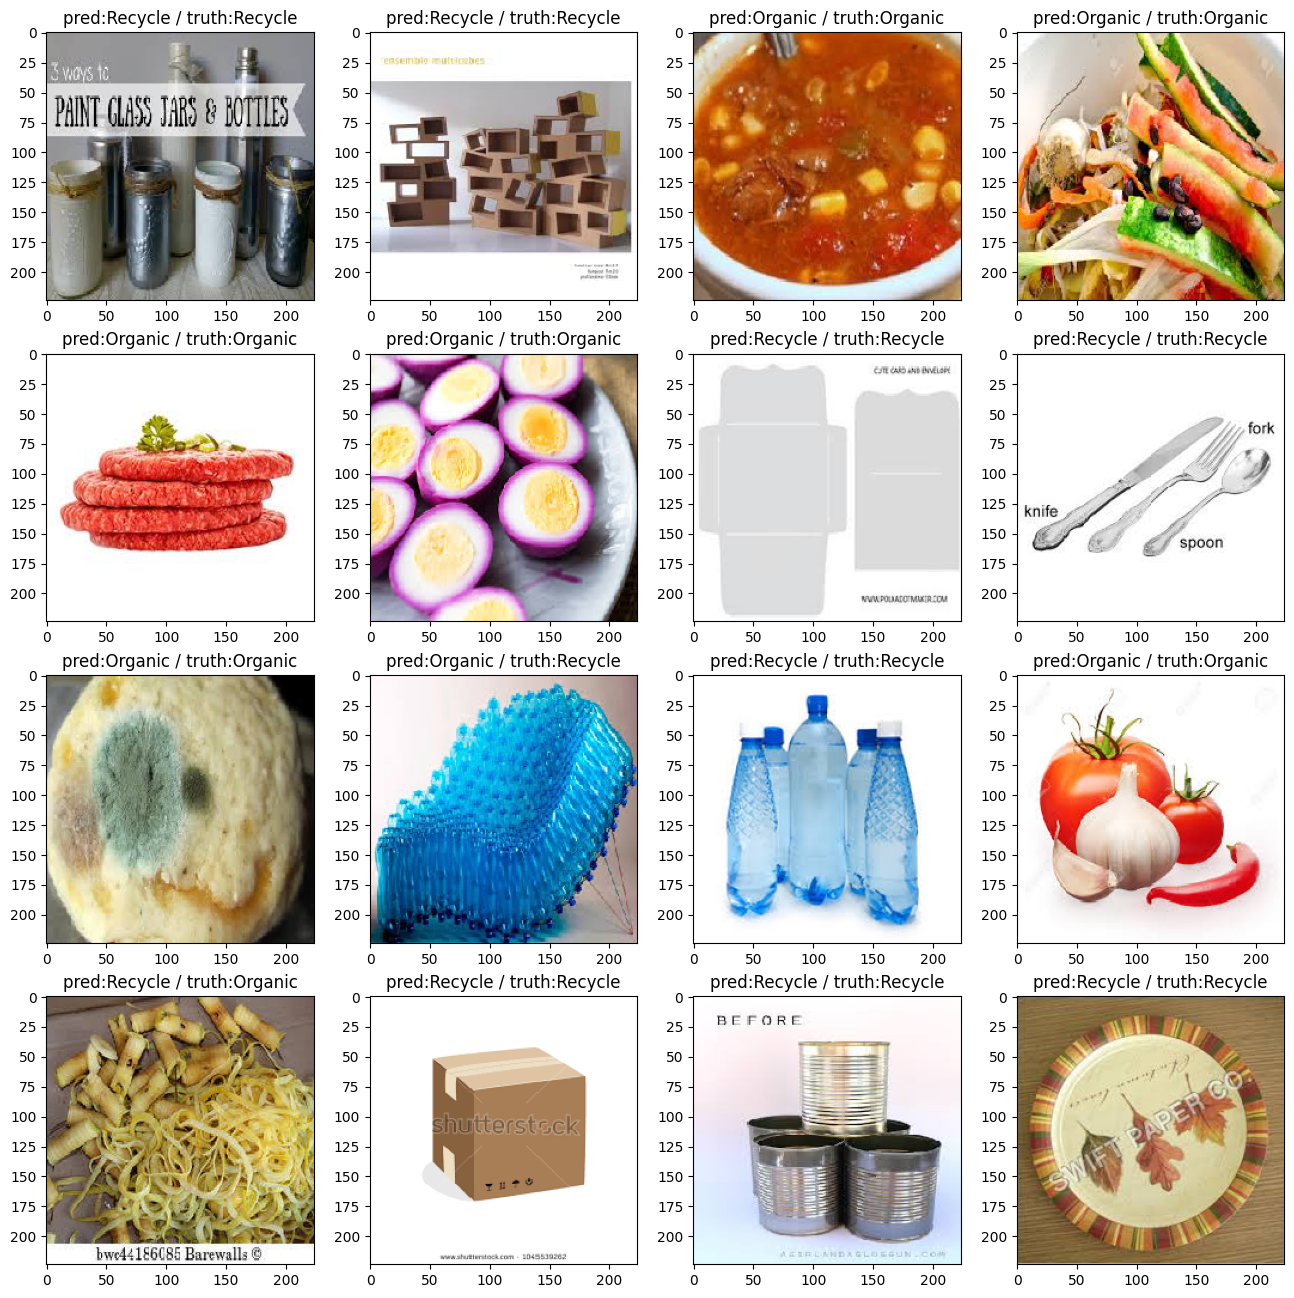

In [ ]:
test_x, test_y = df_test_aug.__getitem__(1)

labels = (df_test_aug.class_indices)
labels = dict((v,k) for k,v in labels.items())

preds = model3.predict(test_x)

plt.figure(figsize=(16, 16))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.title('pred:%s / truth:%s' % (labels[np.argmax(preds[i])], labels[np.argmax(test_y[i])]))
    plt.imshow(test_x[i])

We can see that this is the result of the model predicting the test data. There are 16 images in this visualization where the model predicts correctly as many as 14 images and there are 2 model errors in predicting these images, the images should be organic but the model predicts the label as recycle and vice versa

## VII. MODEL SAVING

In [ ]:
# Saving the model for Future Inferences

model_json = model3.to_json()
with open("model3.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model3.save_weights("model.h5")

## VII. MODEL INFERENCE

In this section I will try to use a new image obtained from Google and the load the data into the notebook.

In [ ]:
# connecting google colab runtime with google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


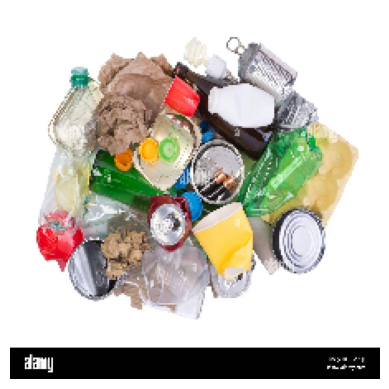

1/1 [==============================] - 0s 198ms/step
[[0. 1.]]
Recycle


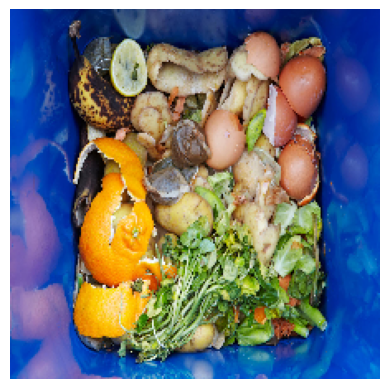

1/1 [==============================] - 0s 20ms/step
[[1. 0.]]
Organic


In [ ]:
 # Predicting new sample image
for path in ['/content/drive/MyDrive/WASTE_CLASSIFICATION_INFERENCE/Recycle_sample.jpg','/content/drive/MyDrive/WASTE_CLASSIFICATION_INFERENCE/Organic_sample.jpg']:
  img = load_img(path, target_size=(img_height, img_width))
  plt.imshow(img)
  plt.axis('Off')
  plt.show()
  x = img_to_array(img)
  x = np.expand_dims(x, axis=0) 

  images = np.vstack([x])
  classes = model3.predict(images)
  print(classes) 

  if classes[0][0].round() == 1:
    print('Organic')
  elif classes[0][1].round() == 1:
    print('Recycle')
  else:
    print('invalid')

The model inference is done by taking data through Google and trying to do recognition using the model that has been created. The model can recognize images well 

---

## VIII. CONCLUSION

Based on the analysis that has been done, we can draw the following conclusions:

A model to classify waste images between organic and recycleable has been created using Sequential Method API.
Based on the models that have been made, there are 3 models where the first model has a training accuracy value of around 56%, the second model (improved model) has a training accuracy of 84%, and the third model (improved model with the addition of VGG16 has a training accuracy of 94% with a the smallest training loss compared to the others.Therefore, the third model is used to conduct trials on the test dataset and produce prediction results accuracy of 90%.
This prediction error can be caused by several factors, such as unclear images, inaccurate image positions, the image size that is not large enough to cause prediction errors and prediction errors can be caused by human error. Even though there are errors in predicting the images, the error value of the deep learning model that has been made is very small because the total data reaches around 5 thousand images.
Thus, the model that has been created can be implemented for further management in overcoming waste problems.

Suggestions for further development:


*   Use another CNN method or maybe try a trained model and then using transfer learning in modeling.
*   More precise image data augmentation
*   Use of more powerful hardware to speed up computing
*   Use of a more varied dataset.